# Scale mutant data
## Load data and set environment 

In [1]:
# Set environment
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pickle
import math as math
import copy
import matplotlib.transforms as mtransforms
from matplotlib import gridspec
import os
import seaborn as sns
import pandas as pd
from scipy import stats

In [11]:
# Import 10nM data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/10nM periodic.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
scorefxn_time_10, scorefxn_data_10 = syntheticdata

In [3]:
# Load scaled WT data
filename = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/modelingEA/experimentaldata_scaled.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    syntheticdata = pickle.load(f)
scorefxn_time, scorefxn_data = syntheticdata

# Predict mutants

In [4]:
# Function to load data
def load_data(dir_path_data, score_cutoff):
    #MSE threshold score at which to not include 
    val_to_keep_end_score = score_cutoff
    
    #load new data:
    arr_best_scores = []
    arr_best_inds = []
    arr_end_scores = []
    dir_to_check = dir_path_data #'/home/iammoresentient/phd_lab/170307_data_sin_y1'
    files = os.listdir(dir_to_check)
    for i in range(0,len(files)):
        filename = dir_to_check + '/' + files[i]
        if os.path.isfile(filename):
            if os.path.getsize(filename) > 0: 
                if '.pickled' in files[i]:
                    #print(filename)
                    arr_to_unpickle = pickle.load(open(filename,'rb'))
                    arr_best_score, arr_best_ind = arr_to_unpickle
                    temp_end_score = arr_best_score[-1]
                    if temp_end_score < val_to_keep_end_score:
                        arr_end_scores.append(temp_end_score)
                        arr_best_scores.append(arr_best_score)
                        arr_best_inds.append(arr_best_ind)


    print('Loaded ' + str(len(arr_best_scores)) + ' files (out of ' + str(len(files)) + ') with cutoff score of ' + str(score_cutoff))

    #convert to numpy
    arr_best_scores = np.asarray(arr_best_scores)
    arr_best_inds = np.asarray(arr_best_inds)
    arr_end_scores = np.asarray(arr_end_scores)

    return arr_best_scores, arr_end_scores, arr_best_inds

In [31]:
# Required functions
def DE(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
    
def signal(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p/2)*slope_on < 0.96:
        maxs = (p/2)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        it = math.floor(t/signal_number)
        if t>=it*p and t < it*p+p/2:
            if t >= it*p and t < it*p+(1/slope_on):
                return ((t-it*p)*slope_on)
            else:
                return 1
        else:
            if t >= it*p+(p/2) and t < maxs/slope_off+(p)/2+p*it:
                return -slope_off*(t-it*p)+maxs+slope_off*p/2
            else:
                return 0
    
def simulate_single_experiment1(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes

In [34]:
# Load data
directory = '/Users/AmyAllen/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Full Model/Digs Degradation/181105_AllDatav3_100g500i10m50c/'
arr_best_scores, arr_end_scores, arr_best_inds=load_data(directory,0.85)
arrT_best_inds = arr_best_inds.transpose()

Loaded 20 files (out of 1402) with cutoff score of 0.85


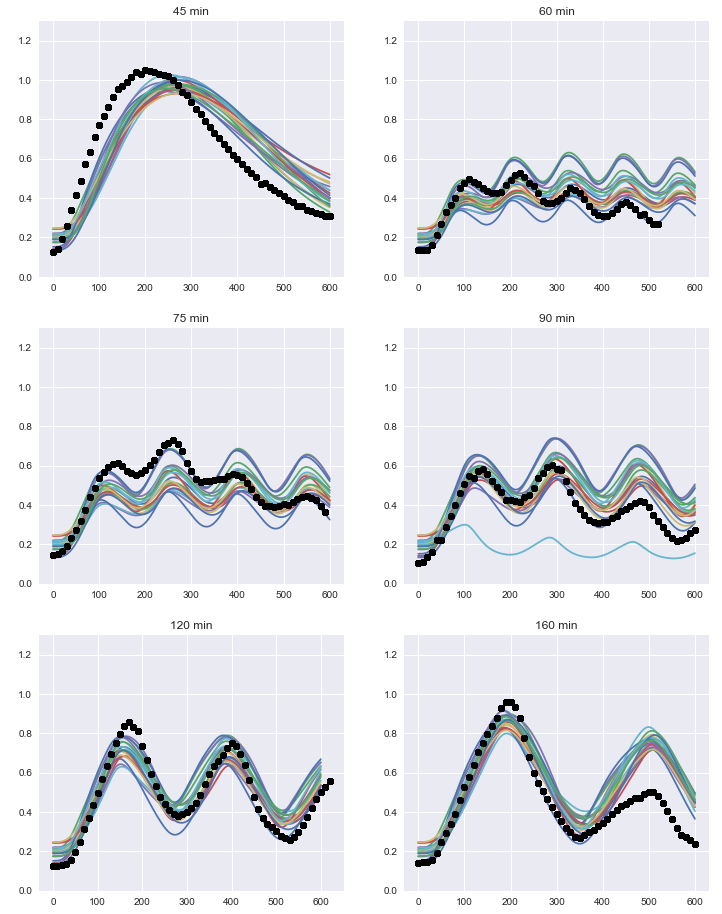

In [45]:
#Specify Figure

#specify scaling factor
sf = 0.2 #on

hc =2

fig = plt.figure(figsize=(12, 16))
gs = gridspec.GridSpec(3, 2)
ax11 = fig.add_subplot(gs[0,0])
ax12 = fig.add_subplot(gs[0,1])
ax21 = fig.add_subplot(gs[1,0])
ax22 = fig.add_subplot(gs[1,1])
ax31 = fig.add_subplot(gs[2,0])
ax32 = fig.add_subplot(gs[2,1])
ax = fig.add_subplot(gs[:,:])

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.grid('off')

IC = [0,0,0,0,0,0,0]
t  = np.linspace(0,40000,100001)
gen = 100
kdegGFP = 10**-1
t1 = np.linspace(0,600,6000)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)

for j in range(len(arr_best_inds[:,gen])):
    for i in range(7):
        expX = 0
        kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP,ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D = arr_best_inds[j][gen]
        if i == 0:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on*sf, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
            odes = odeint(DE, IC, t, args=(0,100,100,))
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 1,SS)
            ax11.plot(t1,expX[:,0])
            ax11.plot(scorefxn_time_10[0],scorefxn_data_10[0],'ko')
            ax11.set_title('45 min')
            ax11.set_ylim([0,1.3])
        elif i == 1:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on*sf, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
            odes = odeint(DE, IC, t, args=(0,100,100,))
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 120,SS)
            ax12.plot(t1,expX[:,0])
            ax12.plot(scorefxn_time_10[2],scorefxn_data_10[2],'ko')
            ax12.set_title('60 min')
            ax12.set_ylim([0,1.3])
        elif i == 2:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on*sf, slope_off, KGFP, KFus3, KSte12, KFar1, kdegS12D
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1, kdegS12D=curr_params
            odes = simulate_single_experiment1(curr_params, t, 0,IC)
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 150,SS)
            ax21.plot(t1,expX[:,0])
            ax21.plot(scorefxn_time_10[3],scorefxn_data_10[3],'ko')
            ax21.set_title('75 min')
            ax21.set_ylim([0,1.3])
        elif i == 4:
            curr_params = 0, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on*sf, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
            odes = simulate_single_experiment1(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 180, SS)
            ax22.plot(t1,expX[:,0])
            ax22.plot(scorefxn_time_10[4],scorefxn_data_10[4],'ko')
            ax22.set_title('90 min')
            ax22.set_ylim([0,1.3])
        elif i == 5:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on*sf, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
            odes = simulate_single_experiment1(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 240,SS)
            ax31.plot(t1,expX[:,0])
            ax31.plot(scorefxn_time_10[5],scorefxn_data_10[5],'ko')
            ax31.set_title('120 min')
            ax31.set_ylim([0,1.3])
        elif i == 6:
            curr_params = kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on*sf, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D
            kdegPF1, ksynF3, kfb1, kp1, kp2, kdegF3, ksynS12, kfb2, kdegS12, kff, km1, ka1, DigsT, ka2, ka3, ksynGFP, ka4, ksynF1, ka5, kp4, kp3, kdegF1, slope_on, slope_off, KGFP, KFus3, KSte12, KFar1,kdegS12D=curr_params
            odes = simulate_single_experiment1(curr_params, t, 0, IC)
            SS=odes[100000,:]
            expX = simulate_single_experiment1(curr_params, t1, 320,SS)
            ax32.plot(t1,expX[:,0])
            ax32.plot(scorefxn_time_10[6],scorefxn_data_10[6],'ko')
            ax32.set_title('160 min')
            ax32.set_ylim([0,1.3])
fig.savefig('low dose predictions.png',dpi=600)